In [1]:
import os
os.chdir("/home/bonzo_yang/github/openai-gym/LunarLander")

In [2]:
from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

%matplotlib inline
import matplotlib.pyplot as plt

from IPython import display

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from tqdm.notebook import tqdm
import random
import gym

In [3]:
seed = 543 # Do not change this
def check_cuda():
    import torch
    
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    gpus = torch.cuda.device_count()
    print(f"{gpus} GPUS are available, set device to {device}")
    return device
    

def fix(env, seed):
    env.reset(seed=seed)# env.seed(seed)
    env.action_space.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.use_deterministic_algorithms(True) # torch.set_deterministic(True)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

引入 OpenAI 的 gym，並建立一個 [Lunar Lander](https://gym.openai.com/envs/LunarLander-v2/) 環境。

In [4]:
env = gym.make('LunarLander-v2', render_mode="rgb_array")
check_cuda()
fix(env, seed)

1 GPUS are available, set device to cuda:0


In [5]:
import time
start = time.time()

## 什麼是 Lunar Lander？

“LunarLander-v2” 這個環境是在模擬登月小艇降落在月球表面時的情形。
這個任務的目標是讓登月小艇「安全地」降落在兩個黃色旗幟間的平地上。
> Landing pad is always at coordinates (0,0).  
> Coordinates are the first two numbers in state vector.  

![](https://gym.openai.com/assets/docs/aeloop-138c89d44114492fd02822303e6b4b07213010bb14ca5856d2d49d6b62d88e53.svg)

所謂的「環境」其實同時包括了 agent 和 environment。
我們利用 `step()` 這個函式讓 agent 行動，而後函式便會回傳 environment 給予的 observation/state（以下這兩個名詞代表同樣的意思）和 reward。

### Observation / State

首先，我們可以看看 environment 回傳給 agent 的 observation 究竟是長什麼樣子的資料：

In [6]:
print(env.observation_space)

Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32)


`Box(8,)` 說明我們會拿到 8 維的向量作為 observation，其中包含：垂直及水平座標、速度、角度、加速度等等，這部分我們就不細說。

### Action

而在 agent 得到 observation 和 reward 以後，能夠採取的動作有：


In [7]:
print(env.action_space)

Discrete(4)


`Discrete(4)` 表示 agent 有 4 種 action 可以執行
`0` - Do nothing  
`1` - Fire left engine (向左加速)
`2` - Fire down engine (向下加速)
`3` - Fire right engine (向右加速)

接下來，我們將嘗試讓 agent 跟 environment 互動。  
在採取任何 action 之前，我們建議調用 `reset()` 函式來重置環境。此外，此函式將 return 環境的初始狀態。


In [8]:
initial_state, initial_info = env.reset()
print(initial_state)

[ 0.00708485  1.4177319   0.7175924   0.30272722 -0.00820268 -0.16254565
  0.          0.        ]


然後，我們嘗試從 agent 的 action space  中獲取隨機 action。

In [9]:
random_action = env.action_space.sample()
print(random_action)

3



此外，我們可以利用 `step()` 使 agent 根據隨機選擇的 `random_action` 進行操作。`step()` 函數將回傳四個值：  
- `observation (object)`: 這將是環境的 :attr: `observation_space` 的一個元素。例如，這可能是一個包含某些對象的位置和速度的 numpy tuple。  
- `reward (float)`: 是否達到 `terminal state` (根據任務的 MDP 定義)。在這種情況下，進一步的 `step()` 呼叫可能會回傳未定義的結果。  
- `terminated (bool)`: 採取 action 後返回的 reward。  
- `truncated (bool)`: 是否滿足 MDP 範圍之外的 truncation 條件。通常是因為 timelimit 造成的，但也可用於表示 agent 是否超出物理範圍。可用在達到 `terminal state` 之前就提前終止 episode。  
- `info (dictionary)`: `info` 包含輔助診斷信息 (有助於 debug、learning 和 logging)。例如，這可能包含：描述 agent 性能狀態的指標、變數，這都隱藏在 observation 或小 reward (最後會累積成總 reward)。它還包含可以分辨 truncation 跟 termination 的資訊，但這種回傳兩個 boolean 值的作法，將不再受到青睞，並且在後續的版本將被棄用。

In [10]:
observation, reward, terminated, truncation, info = env.step(random_action)

In [11]:
print(truncation)

False


### Reward

而「環境」給予的 reward 大致是這樣計算：
- 小艇墜毀得到 -100 分
- 小艇在黃旗幟之間成功著地則得 100~140 分
- 噴射主引擎（向下噴火）每次 -0.3 分
- 小艇最終完全靜止則再得 100 分
- 小艇每隻腳碰觸地面 +10 分

> Reward for moving from the top of the screen to landing pad and zero speed is about 100..140 points.  
> If lander moves away from landing pad it loses reward back.  
> Episode finishes if the lander crashes or comes to rest, receiving additional -100 or +100 points.  
> Each leg ground contact is +10.  
> Firing main engine is -0.3 points each frame.  
> Solved is 200 points.  

In [12]:
print(reward)

-1.6297025784652124


### Random Agent
最後，在開始 train 之前，來看看 random agent 能否成功登陸月球：

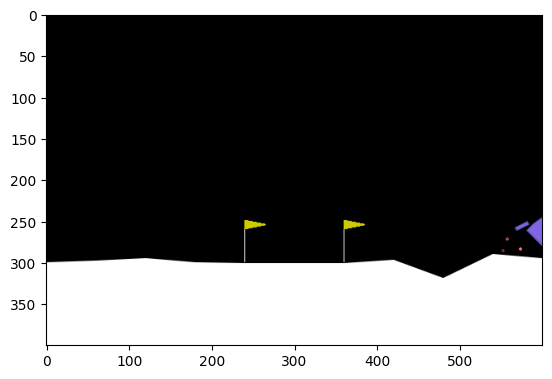

In [13]:
env.reset()

img = plt.imshow(env.render()) # img = plt.imshow(env.render(mode='rgb_array'))

terminated = False
while not terminated:
    action = env.action_space.sample()
    observation, reward, terminated, truncation, info = env.step(action)

    img.set_data(env.render()) # img.set_data(env.render(mode='rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)

## Policy Gradient

現在來搭建一個簡單的 policy network。
我們預設模型的輸入是 8-dim 的 observation，輸出則是離散的四個動作之一：

In [14]:
class PolicyGradientNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(8, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 4)

    def forward(self, state):
        out = nn.LeakyReLU(0.05)(self.fc1(state))
        out = nn.LeakyReLU(0.05)(self.fc2(out))
        out = F.softmax(self.fc3(out), dim=-1)
        return out

再來，搭建一個簡單的 agent，並搭配上方的 policy network 來採取行動。  
這個 agent 能做到以下幾件事：  
- `learn()`：從記下來的 log probabilities 及 rewards 來更新 policy network。  
- `sample()`：從 environment 得到 observation 之後，利用 policy network 得出應該採取的行動。  
而此函式除了回傳抽樣出來的 action，也會回傳此次抽樣的 log probabilities。  

In [15]:
from torch.optim.lr_scheduler import StepLR

class PolicyGradientAgent():
    
    def __init__(self, network, lr=0.001):
        self.network = network
        self.optimizer = optim.SGD(self.network.parameters(), lr=lr)
         
    def forward(self, state):
        return self.network(state)

    def learn(self, log_probs, rewards):
        loss = (-log_probs * rewards).sum() # You don't need to revise this to pass simple baseline (but you can)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
    def sample(self, state):
        action_prob = self.network(torch.FloatTensor(state))
        action_dist = Categorical(action_prob)
        action = action_dist.sample()
        log_prob = action_dist.log_prob(action)
        action = action.item() # only one element tensors can be converted to Python scalars
        return action, log_prob 

    def save(self, PATH): # You should not revise this
        agent_dict = {
            "network" : self.network.state_dict(),
            "optimizer" : self.optimizer.state_dict()
        }
        torch.save(agent_dict, PATH)

    def load(self, PATH): # You should not revise this
        checkpoint = torch.load(PATH)
        self.network.load_state_dict(checkpoint["network"])
        #如果要儲存過程或是中斷訓練後想繼續可以用喔 ^_^
        self.optimizer.load_state_dict(checkpoint["optimizer"])


最後，建立一個 network 和 agent，就可以開始進行訓練了。

In [16]:
network = PolicyGradientNetwork()
agent = PolicyGradientAgent(network)

## 訓練 Agent

現在我們開始訓練 agent。
透過讓 agent 和 environment 互動，我們記住每一組對應的 log probabilities 及 reward，並在成功登陸或者不幸墜毀後，回放這些「記憶」來訓練 policy network。

In [17]:
# class RLTrainer:
#     def __init__(self, agent, env, hp={"episode_per_batch":5, "num_batch":400}):
#         self.agent = agent
#         self.env = env
#         self.hp = hp # hyper parameter
        
#     def shape_check(l):
#         dim = [] 
#         if len(l) > 0:
#             if hasattr(l[0], "shape"):
#                 dim += [_ for _ in l[0].shape]
            
#         dim = tuple(dim)
#         return dim

#     def train():
#         self.
        

SyntaxError: invalid syntax (1382407066.py, line 17)

In [17]:
def int_digits(n):
    import math
    if n == 0:
        return 1
    elif n > 0:
        return int(math.log10(n))+1
    else:
        return int(math.log10(n))+2

In [18]:
agent.network.train()  # 訓練前，先確保 network 處在 training 模式
EPISODE_PER_BATCH = 5  # 每蒐集 5 個 episodes 更新一次 agent
NUM_BATCH = 400        # 總共更新 400 次

avg_total_rewards, avg_final_rewards = [], []
prg_bar = tqdm(range(NUM_BATCH))
for batch in prg_bar:

    log_probs, rewards = [], []
    total_rewards, final_rewards = [], []

    # 蒐集訓練資料
    for episode in range(EPISODE_PER_BATCH):
        
        state, info = env.reset()
        if batch in (197, 252):
           img = plt.imshow(env.render())

        total_reward, total_step = 0, 0
        while True:

            action, log_prob = agent.sample(state) # at , log(at|st)
            next_state, reward, terminated, truncation, info = env.step(action)

            log_probs.append(log_prob) # [log(a1|s1), log(a2|s2), ...., log(at|st)]
            state = next_state
            total_reward += reward
            total_step += 1
            rewards.append(reward) #改這裡
            # ! 重要 ！
            # 現在的reward 的implementation 為每個時刻的瞬時reward, 給定action_list : a1, a2, a3 ......
            #                                                       reward :     r1, r2 ,r3 ......
            # medium：將reward調整成accumulative decaying reward, 給定action_list : a1,                         a2,                           a3 ......
            #                                                       reward :     r1+0.99*r2+0.99^2*r3+......, r2+0.99*r3+0.99^2*r4+...... ,r3+0.99*r4+0.99^2*r5+ ......
            # boss : implement DQN
            # if done:


            # action = env.action_space.sample()
            # observation, reward, terminated, truncation, info = env.step(action)

            if batch in (197, 252):
                img.set_data(env.render()) # img.set_data(env.render(mode='rgb_array'))
                display.display(plt.gcf())
                display.clear_output(wait=True)
                msg = f"batch {batch:{int_digits(NUM_BATCH)}d}, episode:{episode}, steps {total_step: 8d}, rewards.shape: {torch.from_numpy(np.array(rewards)).size()}, log_probs.shape: {torch.stack(log_probs).size()}"
                print(msg, end='\r')


            if terminated:
                final_rewards.append(reward)
                total_rewards.append(total_reward)
                break
        
            



    # 紀錄訓練過程
    avg_total_reward = sum(total_rewards) / len(total_rewards)
    avg_final_reward = sum(final_rewards) / len(final_rewards)
    avg_total_rewards.append(avg_total_reward)
    avg_final_rewards.append(avg_final_reward)
    prg_bar.set_description(f"Total: {avg_total_reward: 4.1f}, Final: {avg_final_reward: 4.1f}")

    # 更新網路
    rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-9)  # 將 reward 正規標準化
    agent.learn(torch.stack(log_probs), torch.from_numpy(rewards))


    msg = f"batch {batch:{int_digits(NUM_BATCH)}d}, episode:{episode}, steps {total_step: 8d}, rewards.shape: {torch.from_numpy(rewards).size()}, log_probs.shape: { torch.stack(log_probs).size()}"
    print(msg, end='\r')
    # print("logs prob looks like ", torch.stack(log_probs).size())
    # print("torch.from_numpy(rewards) looks like ", torch.from_numpy(rewards).size())